In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from numpy.random import seed
seed(42)
import tensorflow
tensorflow.random.set_seed(42)

In [3]:
import numpy as np
import pandas as pd
import util.common as util
from tensorflow import keras

# Load Data

In [33]:
clean_dir = "/project/data/cicids2017/clean/"
x_binary_train, y_binary_train, x_binary_val, y_binary_val, x_binary_test, y_binary_test, x_multi_train, y_multi_train, x_multi_test, y_multi_test = util.load_data(clean_dir, train_size=100000, sample_size=1948)

(D)DOS          321637
Port Scan        90694
Brute Force       9150
Web Attack        2143
Botnet            1948
Infiltration        36
Heartbleed          11
Name: Label, dtype: int64
Attack type:    #Original:     #Sampled:      #Train:       #Test:
      (D)DOS        321637          1948         1363          585
      Botnet          1948          1948         1363          585
 Brute Force          9150          1948         1363          585
  Heartbleed            11            11            0           11
Infiltration            36            36            0           36
   Port Scan         90694          1948         1363          585
  Web Attack          2143          1948         1363          585


In [34]:
x_train = x_multi_train
y_train = y_multi_train
x_test = np.concatenate((x_binary_train[-585:], x_multi_test))
y_test = np.concatenate((np.full(585, "Benign"), y_multi_test))
y_test[y_test == "Heartbleed"] = "Unknown"
y_test[y_test == "Infiltration"] = "Unknown"

In [35]:
np.unique(y_train, return_counts=True)

(array(['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack'],
       dtype=object),
 array([1363, 1363, 1363, 1363, 1363]))

In [36]:
np.unique(y_test, return_counts=True)

(array(['(D)DOS', 'Benign', 'Botnet', 'Brute Force', 'Port Scan',
        'Unknown', 'Web Attack'], dtype=object),
 array([585, 585, 585, 585, 585,  47, 585]))

# Rescale Data

In [37]:
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, MinMaxScaler

binary_scaler = QuantileTransformer(output_distribution='normal')
x_binary_train_s = binary_scaler.fit_transform(x_binary_train)
x_binary_val_s = binary_scaler.transform(x_binary_val)
x_train_1 = binary_scaler.transform(x_train)
x_test_1 = binary_scaler.transform(x_test)

# Load Binary Model

In [38]:
study_name = "TWOS-37"
trial_number = 1223
path = f'results/binary/autoencoder/{study_name}/models/model_{trial_number}.h5'

In [67]:
model_1 = keras.models.load_model(path)
print(model_1.summary())

Model: "model_305"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_306 (InputLayer)       [(None, 67)]              0         
_________________________________________________________________
dense_1322 (Dense)           (None, 66)                4488      
_________________________________________________________________
dense_1323 (Dense)           (None, 63)                4221      
_________________________________________________________________
dense_1324 (Dense)           (None, 66)                4224      
_________________________________________________________________
dense_1325 (Dense)           (None, 67)                4489      
Total params: 17,422
Trainable params: 17,422
Non-trainable params: 0
_________________________________________________________________
None


In [93]:
threshold_b = 11.5

In [94]:
x_predict = model_1.predict(x_train_1)
score_train = util.anomaly_scores(x_train_1, x_predict)
x_predict = model_1.predict(x_test_1)
score_test = util.anomaly_scores(x_test_1, x_predict)
y_pred_1 = np.where(score_test < threshold_b, 1, -1)

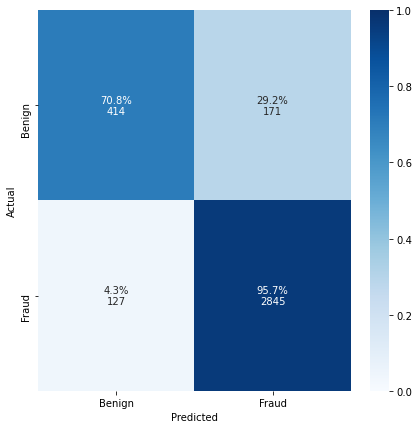

In [95]:
fig = util.plot_confusion_matrix(np.where(y_test == "Benign", 1, -1), y_pred_1, values=[1, -1], labels=["Benign", "Fraud"])

## Concat Anomaly Score as Feature

In [96]:
x_train_2 = np.column_stack((x_train, score_train))
x_test_2 = np.column_stack((x_test, score_test))

In [97]:
scalers = {
    'standard': StandardScaler(),
    'robust': RobustScaler(quantile_range=(25, 75)),
    'quantile': QuantileTransformer(output_distribution='normal'),
    'minmax': MinMaxScaler(feature_range=(0, 1), copy=True)
}
x_test_s = {}
for key, value in scalers.items():
    value.fit(x_train_2)
    x_test_s[key] = value.transform(x_test_2)

# Load Multi-Class model

In [98]:
import pickle
from sklearn.ensemble import RandomForestClassifier

study_name = "TWOS1-4"
trial_number = 113
save_dir = f'results/multi/randomforest/{study_name}'
f = open(f'{save_dir}/models/model_{trial_number}.p', 'rb')
model = pickle.load(f)
f.close()

In [117]:
threshold_m = 0.345
scaler = "quantile"

In [118]:
# Only classify malicious predicted samples by previous stage
y_proba = model.predict_proba(x_test_s[scaler][y_pred_1 == -1])
y_pred_2 = np.where(np.max(y_proba, axis=1) > threshold_m, model.classes_[np.argmax(y_proba, axis=1)], 'Unknown')

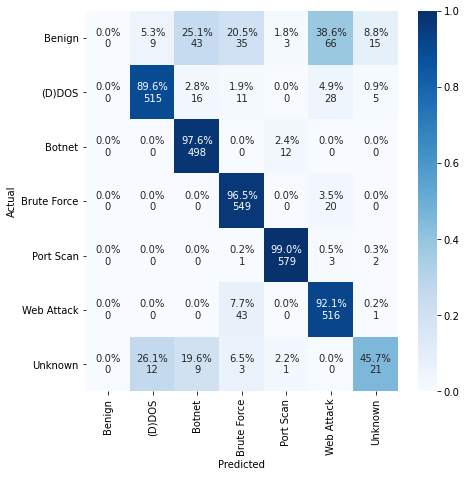

In [119]:
classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
fig = util.plot_confusion_matrix(y_test[y_pred_1 == -1], y_pred_2, values=classes, labels=classes)

In [120]:
final_pred = np.full(len(y_test), "", dtype=object)
final_pred[y_pred_1 == 1] = "Benign"
final_pred[y_pred_1 == -1] = y_pred_2
final_pred

array(['Benign', 'Benign', 'Botnet', ..., 'Port Scan', 'Benign',
       'Brute Force'], dtype=object)

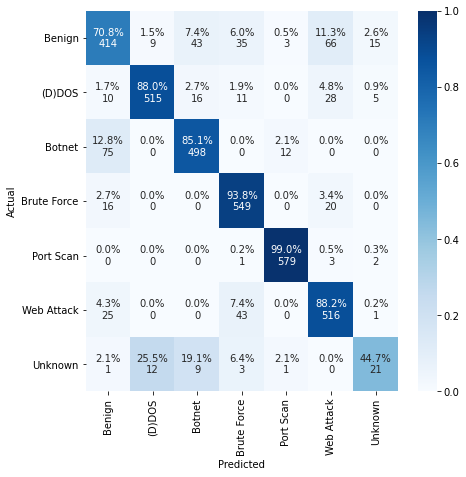

In [121]:
fig = util.plot_confusion_matrix(y_test, final_pred, values=classes, labels=classes)

In [122]:
from sklearn.metrics import f1_score
f1_score(y_test, final_pred, average='macro')

0.8149362700393485

## Find Optimal Threshold

In [147]:
from sklearn.metrics import f1_score
from tqdm import tqdm

thresholds = np.arange(0.0, 1.0, 0.005)
fscore = np.zeros(shape=(len(thresholds)))

# Fit the model
for index, threshold in tqdm(enumerate(thresholds)):
    # Corrected probabilities
    y_pred = np.where(np.max(y_proba, axis=1) > threshold, forest.classes_[np.argmax(y_proba, axis=1)], 'Unknown')
    # Calculate the f-score
    fscore[index] = f1_score(y_test, y_pred, average='macro', labels=['(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack'])

# Find the optimal threshold
index = np.argmax(fscore)
thresholdOpt = round(thresholds[index], ndigits = 4)
fscoreOpt = round(fscore[index], ndigits = 4)
print('Best Threshold: {} with F-Score: {}'.format(thresholdOpt, fscoreOpt))

200it [00:04, 41.14it/s]

Best Threshold: 0.98 with F-Score: 0.8564


In [136]:
threshold = thresholdOpt
y_pred = np.where(np.max(y_proba, axis=1) > threshold, forest.classes_[np.argmax(y_proba, axis=1)], 'Unknown')

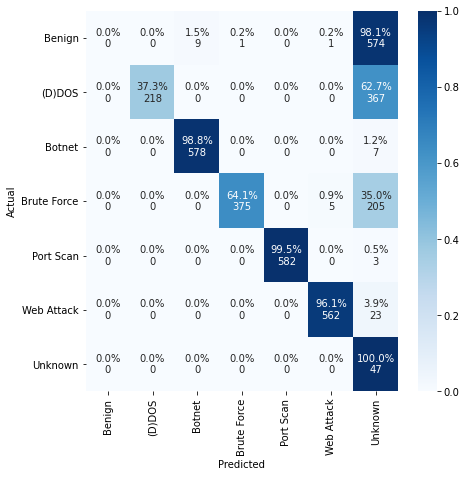

In [134]:
classes = ['Benign', '(D)DOS', 'Botnet', 'Brute Force', 'Port Scan', 'Web Attack', 'Unknown']
fig = util.plot_confusion_matrix(y_test, y_pred, values=classes, labels=classes)

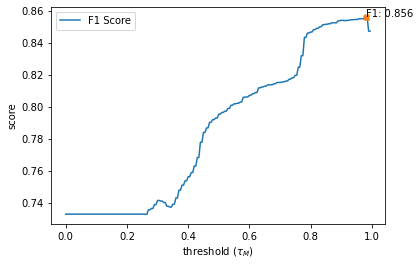

In [148]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(thresholds, fscore, label="F1 Score")
plt.plot(thresholdOpt, fscoreOpt, marker="X")
plt.annotate(f"F1: {str(round(fscoreOpt, 3))}", (thresholdOpt, fscoreOpt))
plt.xlabel(r"threshold ($\tau_M$)")
plt.ylabel("score")
plt.legend()